In [34]:
import awkward as ak
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from codes.plotting import plot_prettier 
#plot_prettier()

In [35]:
data = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\ntup_tracks.json"))
data1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\makeMuonPlots.json"))

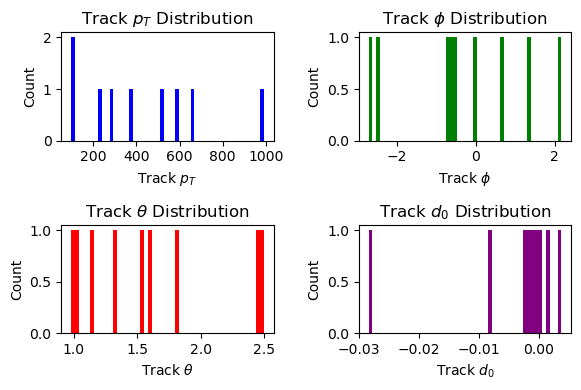

In [36]:
# Extract the required arrays from the data
track_pt = data['track_pt']
track_phi = data['track_phi']
track_theta = data['track_theta']
track_d0 = data['track_d0']
track_z0 = data['track_z0']
track_chi2 = data['track_chi2']
track_ndof = data['track_ndof']

# Create histograms
plt.figure(figsize=(6, 4))

# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(track_pt), bins=50, color='blue')
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution')

# Histogram for track phi
plt.subplot(2, 2, 2)
plt.hist(ak.flatten(track_phi), bins=50, color='green')
plt.xlabel('Track $\\phi$')
plt.ylabel('Count')
plt.title('Track $\\phi$ Distribution')

# Histogram for track theta
plt.subplot(2, 2, 3)
plt.hist(ak.flatten(track_theta), bins=50, color='red')
plt.xlabel('Track $\\theta$')
plt.ylabel('Count')
plt.title('Track $\\theta$ Distribution')

# Histogram for track d0
plt.subplot(2, 2, 4)
plt.hist(ak.flatten(track_d0), bins=50, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title('Track $d_0$ Distribution')

# Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()


In [37]:
data

<Record {truth_pt: [[525], ...], ...} type='{truth_pt: var * var * float64,...'>

In [38]:
data1

<Record {mcp_pt: [[198], ...], ...} type='{mcp_pt: var * var * float64, mcp...'>

In [42]:
mcp_pt = data1['mcp_pt']
mcp_eta = data1['mcp_eta']
mcp_phi = data1['mcp_phi']
pfo_pt = data1['pfo_pt']
pfo_eta = data1['pfo_eta']
pfo_phi = data1['pfo_phi']
pfo_mu_pt = data1['pfo_mu_pt']
pfo_mu_eta = data1['pfo_mu_eta']
pfo_mu_phi = data1['pfo_mu_phi']
mcp_mu_pt = data1['mcp_mu_pt']
mcp_mu_eta = data1['mcp_mu_eta']
mcp_mu_phi = data1['mcp_mu_phi']
mcp_mu_match_pt = data1['mcp_mu_match_pt']
mcp_mu_match_eta = data1['mcp_mu_match_eta']
mcp_mu_match_phi = data1['mcp_mu_match_phi']
d_mu_dpt = data1['d_mu_dpt']
d_mu_drelpt = data1['d_mu_drelpt']
d_mu_dphi = data1['d_mu_dphi']
d_mu_deta = data1['d_mu_deta']
nhits = data1['nhits']
pt_res_hits = data1['pt_res_hits']
pt_res_vs_eta = data1['pt_res_vs_eta']
pt_res_vs_pt = data1['pt_res_vs_pt']
d0_res_vs_pt = data1['d0_res_vs_pt']
d0_res_vs_eta = data1['d0_res_vs_eta']
z0_res_vs_pt = data1['z0_res_vs_pt']
z0_res_vs_eta = data1['z0_res_vs_eta']
d0_res = data1['d0_res']
z0_res = data1['z0_res']
pt_res = data1['pt_res'] 
pt_match = data1['pt_match']
eta_match = data1['eta_match']
d0_res_match = data1['d0_res_match']
z0_res_match = data1['z0_res_match']
h2d_relpt = data1['h_2d_relpt']

In [63]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", xlim = None, ylim = None, stats = True):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        counts, bin_edges = np.histogram(data_flaty, bins=bins)
        half_max = np.max(counts) / 2.0
        fwhm_value = bin_edges[np.argmax(counts >= half_max)] - bin_edges[np.argmax(counts >= half_max) - 1]
        
        # Create a text box to display statistics
        stats_text = 'FWHM '+ylabel+f':{fwhm_value:.2f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

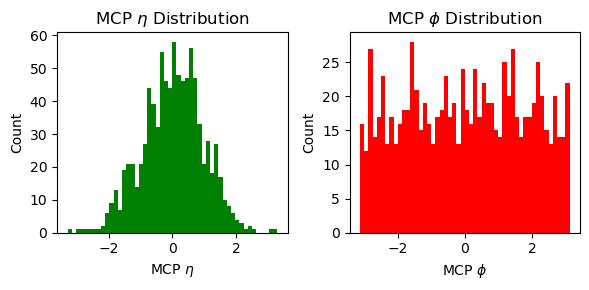

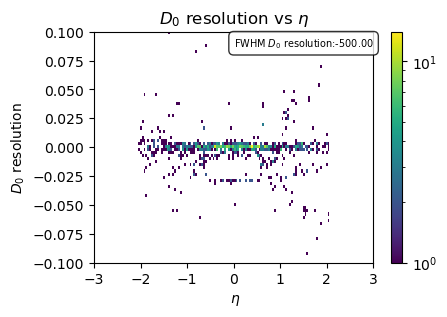

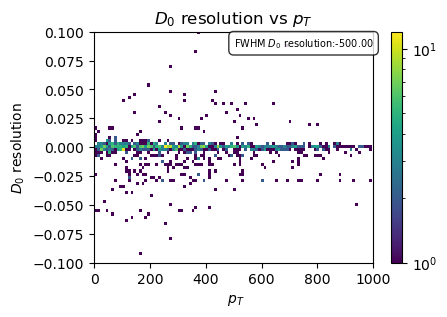

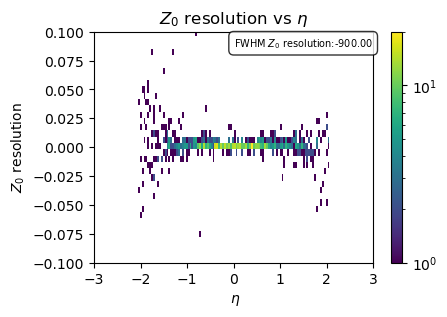

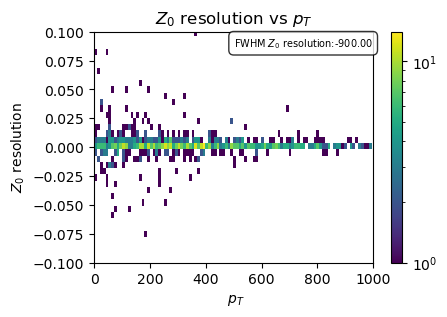

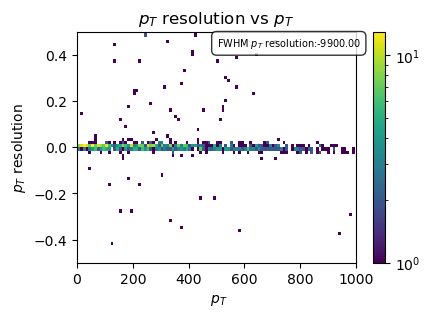

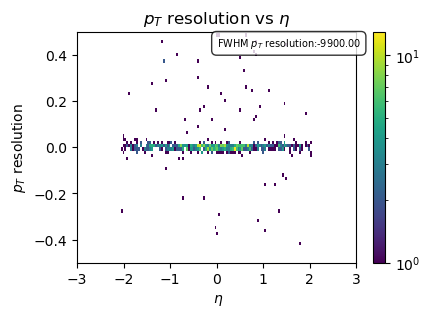

In [64]:
# Histogram for mcp_eta

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.hist((mcp_eta), bins=50, color='green')
plt.xlabel('MCP $\\eta$')
plt.ylabel('Count')
plt.title('MCP $\\eta$ Distribution')

# Histogram for mcp_phi
plt.subplot(1, 2, 2)
plt.hist((mcp_phi), bins=50, color='red')
plt.xlabel('MCP $\\phi$')
plt.ylabel('Count')
plt.title('MCP $\\phi$ Distribution')

# # Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()

plot2DHistogram(eta_match, d0_res_match, bins=(100,600), label=r"$D_0$ resolution vs $\eta$; $\eta$;$D_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
plot2DHistogram(pt_match, d0_res_match, bins=(100,600), label=r"$D_0$ resolution vs $p_T$; $p_T$;$D_0$ resolution", xlim = (0,1000), ylim = (-0.1,0.1))
plot2DHistogram(eta_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $\eta$; $\eta$;$Z_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
plot2DHistogram(pt_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $p_T$; $p_T$;$Z_0$ resolution", xlim = (0,1000), ylim = (-0.1,0.1))
plot2DHistogram(pt_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $p_T$; $p_T$;$p_T$ resolution", xlim = (0,1000), ylim = (-0.5,0.5))
plot2DHistogram(eta_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $\eta$; $\eta$;$p_T$ resolution", xlim = (-3,3), ylim = (-0.5,0.5))


Text(0.5, 1.0, 'PFO $p_T$ Resolution')

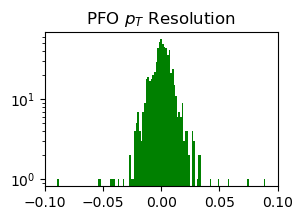

In [58]:

plt.figure(figsize=(3, 2))

plt.hist((np.ravel(pt_res)), bins=10000, color='green')
plt.yscale('log')
plt.xlim(-0.1,0.1)
plt.title('PFO $p_T$ Resolution')